In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
file_path = './HW_1_Data.xls'

In [14]:
f = pd.ExcelFile(file_path)
sheet_data = f.parse(0)

In [32]:
print(sheet_data.head())
print("Length of data:", len(sheet_data))

               Date  GLD _DailyClose
0      '2004-11-18'            44.38
1      '2004-11-19'            44.78
2      '2004-11-22'            44.95
3      '2004-11-23'            44.75
4      '2004-11-24'            45.05
Length of data: 1468


In [44]:
dates = sheet_data["Date"]
price = sheet_data["GLD _DailyClose"]

## I. Original ClosePrice Data

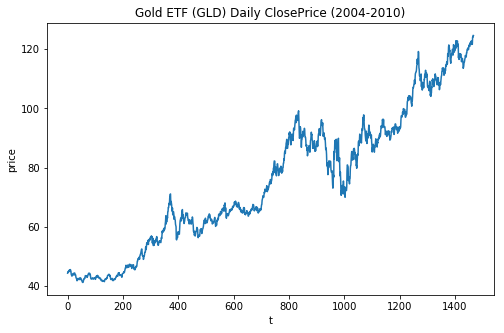

In [46]:
plt.figure(figsize=(8,5))
plt.plot(price)
plt.title('Gold ETF (GLD) Daily ClosePrice (2004-2010)')
plt.xlabel('t')
plt.ylabel('price')
plt.savefig('./pics/closePrice.png',dpi=300)

## II. Remove the linear trend

Coefficients: [ 36.85097198   0.05311203]


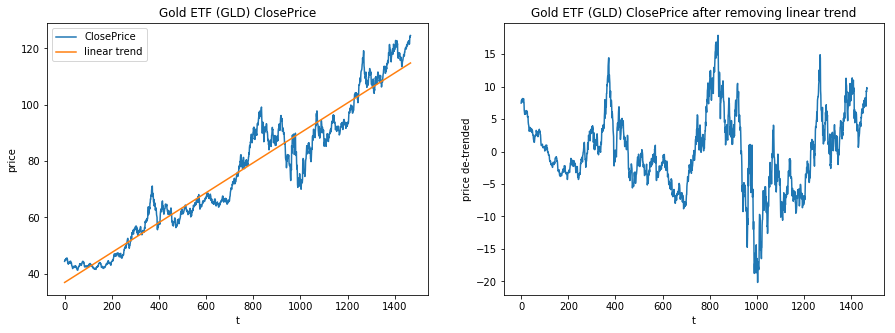

In [222]:
#print(np.ones(len(price)))
#print(np.arange(1,len(price)+1))
design_matrix = np.hstack((np.ones(len(price)).reshape(-1,1), np.arange(1,len(price)+1).reshape(-1,1)))

beta, residual, rank, sv = np.linalg.lstsq(design_matrix, price)
print("Coefficients:", beta)
pred_price = np.dot(design_matrix, beta)
price_detrend = price - pred_price

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(price)
plt.plot(pred_price)
plt.xlabel('t')
plt.ylabel('price')
plt.legend(['ClosePrice','linear trend'])
plt.title('Gold ETF (GLD) ClosePrice')

plt.subplot(122)
plt.plot(price_detrend)
plt.xlabel('t')
plt.ylabel('price de-trended')
plt.title('Gold ETF (GLD) ClosePrice after removing linear trend')
plt.savefig('./pics/linear_trend.png', dpi=300)

### Sample Autocorrelation Function (ACF) for de-trended data

In [116]:
def pacf(sequence):
    partcorr = np.zeros(len(sequence))
    partcorr[0] = 1
    partcorr[1] = acf(1, sequence)
    for i in range(2,len(partcorr)):
        x_t = sequence[:-i]
        x_tpi = sequence[i:]
        control_matrix = np.zeros((x_t.shape[0],i-1))
        for j in range(i-1):
            control_matrix[:,j] = sequence[j:len(sequence)-i+j]
        beta_t = np.linalg.lstsq(control_matrix, x_t)[0]
        beta_ti = np.linalg.lstsq(control_matrix, x_tpi)[0]
        
        res_t = x_t - control_matrix.dot(beta_t)
        res_ti = x_tpi - control_matrix.dot(beta_ti)
        
        partcorr[i] = np.corrcoef(res_t, res_ti)[0,1]
    
    return partcorr

In [100]:
sample_mean = np.mean(price_detrend)

def acf(t, sequence):
    mu = np.mean(sequence)
    return np.sum([(sequence[i] - mu)*(sequence[i+t]-mu) for i in range(len(sequence)-t)])/len(sequence)

# Initialization
sample_acf = np.arange(len(price))
sample_acf = np.array([acf(lag, price_detrend) for lag in sample_acf])
sample_acf = sample_acf / sample_acf[0]

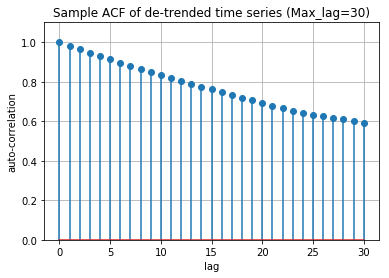

In [237]:
#plt.plot(sample_acf[:50],'ro')
plt.figure(figsize=(6,4))
plt.stem(sample_acf[:31])
plt.xlabel('lag')
plt.ylabel('auto-correlation')
plt.title('Sample ACF of de-trended time series (Max_lag=30)')
plt.ylim((0,1.1))
plt.grid()
plt.savefig('./pics/myacf.png',dpi=300)


In [117]:
mypacf = pacf(price_detrend)

/Users/xliu/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3154: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/xliu/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3088: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/Users/xliu/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3088: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


### Model Selection (ACF + PACF)
__(Estimate the order for ARMA process)__

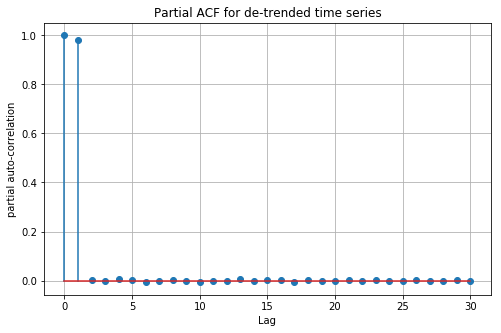

In [244]:
#mypacf[1] = mypacf[1] * acf(0,price_detrend)
plt.figure(figsize=(8,5))
plt.stem(mypacf[:31])
plt.grid()
#plt.ylim([-0.2,1.1])
plt.xlabel('Lag')
plt.ylabel('partial auto-correlation')
plt.title('Partial ACF for de-trended time series')
plt.savefig('./pics/mypacf.png', dpi=300)

/Users/xliu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


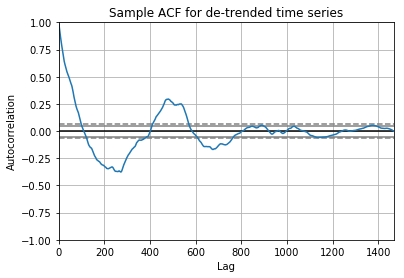

In [238]:
from pandas.tools.plotting import autocorrelation_plot
plt.figure(figsize=(6,4))
autocorrelation_plot(price_detrend)
plt.title('Sample ACF for de-trended time series')
plt.savefig('./pics/pandas_acf.png',dpi=300)

### Parameter Calibration

In [164]:
from statsmodels.tsa.arima_model import AR

In [178]:
ar_train = pd.Series(price_detrend.data, index=sheet_data.Date)

Date
    '2004-11-18'    7.475916
    '2004-11-19'    7.822804
    '2004-11-22'    7.939692
    '2004-11-23'    7.686580
    '2004-11-24'    7.933468
dtype: float64


In [250]:
model = AR(ar_train)
model_fitted = model.fit(maxlag=1)

print("Parameters:")
print(model_fitted.params,"\n")
print("Estimated sigma^2:", model_fitted.sigma2)

Parameters:
const    0.001419
L1.y     0.983170
dtype: float64 

Estimated sigma^2: 1.21206257801


## III. First Difference of the original data

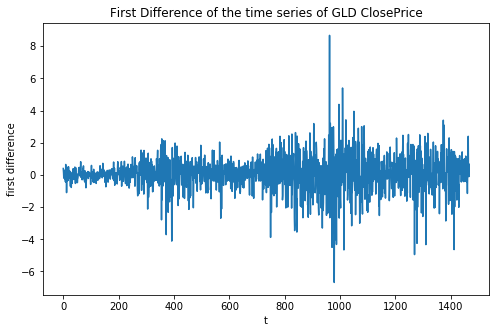

In [259]:
price_diff = np.diff(price)

plt.figure(figsize=(8,5))
plt.plot(price_diff)
plt.xlabel('t')
plt.ylabel('first difference')
plt.title('First Difference of the time series of GLD ClosePrice')
plt.savefig('./pics/first_diff.png', dpi=300)

/Users/xliu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  """Entry point for launching an IPython kernel.


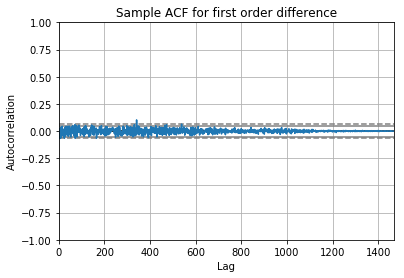

In [266]:
autocorrelation_plot(price_diff)
plt.title('Sample ACF for first order difference')
plt.savefig('./pics/diffacf_pandas.png', dpi=300)

In [261]:
diff_acf = np.arange(len(price_diff))
diff_acf = np.array([acf(lag, price_diff) for lag in diff_acf])
diff_acf = diff_acf / diff_acf[0]

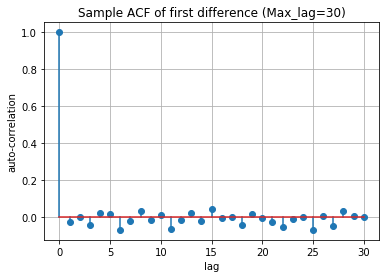

In [265]:
plt.figure(figsize=(6,4))
plt.stem(diff_acf[:31])
plt.xlabel('lag')
plt.ylabel('auto-correlation')
plt.title('Sample ACF of first difference (Max_lag=30)')
#plt.ylim((0,1.1))
plt.grid()
plt.savefig('./pics/diffacf.png',dpi=300)

In [268]:
print("Estimated sigma2:", np.var(price_diff))

Estimated sigma2: 1.22212534909
